# Drafting with ML

Some beginning assumptions: 

1. [ADP is informative as a "wisdom of the crowd"](#adp)
2. [Some insight can be gleaned from studying past winners of our league](#champs). The 3 time reigning champion - Jose (aka `4th and 20`) knows something I don't.
3. I have a half-baked notion that I could write a [RL model](#rlmodel) that would take in state of the draft and recommend a next pick. 

In [176]:
import pandas as pd
%matplotlib inline

<a id="adp"></a>
## Assumption #1: ADP

[Sporting News](https://www.sportingnews.com/us/fantasy/news/2021-fantasy-football-ppr-rankings-top-200-cheat-sheet/crje0sv7d07i1pua67hcitq6z)

In [16]:
sporting_news_top_200 = pd.read_parquet("data/sporting-news-top-200.parquet")
fantasy_pros = pd.read_csv("data/FantasyPros-consensus-rankings.csv")
walter_football = pd.read_excel("data/fantasy2021rankingsexcel.xlsx")

Let's check those out

In [3]:
sporting_news_top_200

,Rank,Player,Position
0,1,"Christian McCaffrey, Panthers",RB
1,2,"Alvin Kamara, Saints",RB
2,3,"Saquon Barkley, Giants",RB
3,4,"Dalvin Cook, Vikings",RB
4,5,"Derrick Henry, Titans",RB
...,...,...,...
195,196,Arizona Cardinals,D/ST
196,197,Minnesota Vikings,D/ST
197,198,Cleveland Browns,D/ST
198,199,"Marlon Mack, Colts",RB


In [17]:
fantasy_pros

,Rank,Player Name,Team,Andy Behrens,Scott Pianowski,Staff Composite,Dalton Del Don,Liz Loza,Matt Harmon
0,1,Christian McCaffrey,CAR,1.0,1.0,NaN,1.0,1.0,1.0
1,2,Dalvin Cook,MIN,2.0,2.0,NaN,2.0,2.0,2.0
2,3,Ezekiel Elliott,DAL,4.0,3.0,NaN,4.0,3.0,3.0
3,4,Derrick Henry,TEN,3.0,4.0,NaN,6.0,4.0,4.0
4,5,Alvin Kamara,NO,5.0,5.0,NaN,3.0,5.0,7.0
...,...,...,...,...,...,...,...,...,...
347,348,Steven Sims Jr.,PIT,NaN,NaN,NaN,NaN,NaN,335.0
348,349,Andrew Jacas,SF,NaN,NaN,NaN,NaN,NaN,336.0
349,350,Greg Ward,PHI,NaN,NaN,NaN,NaN,NaN,338.0
350,351,Gardner Minshew II,PHI,NaN,NaN,NaN,NaN,NaN,339.0


In [18]:
walter_football

,Last Name,First Name,Team,Bye,Pos,PASS YDS,PASS TD,INT,RUSH YDS,CATCH,...,VBD TD,Points (2QB),VBD 2QB,Points (Custom),VBD Custom,Unnamed: 24,VBD Mods,QBs,Vmodes,QB
0,Mahomes,Patrick,Chiefs,12,QB,5100,47,7,280,NaN,...,56,377,167,377,76,NaN,Drafteds,15,V_Reg,301
1,Murray,Kyler,Cardinals,12,QB,4400,34,14,780,NaN,...,27,357,147,357,56,NaN,Starters,12,V-PPR,301
2,Allen,Josh,Bills,7,QB,4800,39,13,390,NaN,...,40,356,146,356,55,NaN,Active Starters,1,V-TD,209
3,Jackson,Lamar,Ravens,8,QB,3500,31,11,900,NaN,...,18,340,130,340,39,NaN,NaN,NaN,V-2QB,210
4,Rodgers,Aaron,Packers,13,QB,4900,40,8,130,NaN,...,27,334,124,334,33,NaN,NaN,NaN,NaN,NaN
5,Wilson,Russell,Seahawks,9,QB,4800,37,12,420,NaN,...,12,331,121,331,30,NaN,NaN,NaN,NaN,NaN
6,Herbert,Justin,Chargers,7,QB,4800,35,15,260,NaN,...,15,321,111,321,20,NaN,VBD Mods,QBs,Vmodes,QB
7,Brady,Tom,Buccaneers,9,QB,4700,40,12,20,NaN,...,26,319,109,319,18,NaN,Drafteds,15,V-Custom,301
8,Stafford,Matthew,Rams,11,QB,4800,33,13,100,NaN,...,10,308,98,308,7,NaN,Starters,12,NaN,NaN
9,Winston,Jameis,Saints,6,QB,4400,30,20,200,NaN,...,17,306,96,306,5,NaN,Active Starters,1,NaN,NaN


ESPN also publishes an average draft position but there's 22 pages and I don't want to copy paste that ish so here's a crawler

<img src = "assets/espn-adp.png">

In [37]:
from selenium import webdriver
from bs4 import BeautifulSoup
from time import sleep


In [45]:
driver = webdriver.Firefox()
driver.get("https://fantasy.espn.com/football/livedraftresults")
all_adps = []
for i in range(1,23):
    #looks like a ton of images. sleeping to make sure it loads
    sleep(3)
    # pandas is so smart now
    df = pd.read_html(driver.page_source)
    # first item is the dataframe
    df = df[0]
    # the dataframe is a multi-index so get rid of the top. column names are descriptive as is
    df.columns = df.columns.droplevel()
    all_adps.append(df)
    # advance to next page
    next_button = driver.find_element_by_xpath('/html/body/div[1]/div[1]/div/div/div[5]/div[2]/div[2]/div/div/div/div[3]/nav/button[2]')
    next_button.click()
    # cheap logging
    print("I'm on page", i)
driver.close()

I'm on page 1
I'm on page 2
I'm on page 3
I'm on page 4
I'm on page 5
I'm on page 6
I'm on page 7
I'm on page 8
I'm on page 9
I'm on page 10
I'm on page 11
I'm on page 12
I'm on page 13
I'm on page 14
I'm on page 15
I'm on page 16
I'm on page 17
I'm on page 18
I'm on page 19
I'm on page 20
I'm on page 21
I'm on page 22


In [56]:
avg_draft_postn = pd.concat(all_adps) 

In [57]:
avg_draft_postn = avg_draft_postn.reset_index(drop=True)

In [62]:
avg_draft_postn.columns

Index(['Rank', 'Player', 'AVG PICK', '7 DAY +/-', 'AVG SALARY', '7 DAY +/-',
       '%ROST'],
      dtype='object')

In [510]:
#avg_draft_postn.to_csv("data/average-draft-position-espn.csv", index=False)
avg_draft_postn = pd.read_csv("data/average-draft-position-espn.csv")

Let's compare the experts with ADP

In [511]:
nfl_team_abbrv = list(fantasy_pros['Team'].values)
nfl_team_abbrv = list(set(nfl_team_abbrv))

In [512]:
nfl_team_title = [x.title() for x in nfl_team_abbrv]

In [513]:
"|".join(nfl_team_title)

'Tb|Buf|Ne|Sf|Gb|Bal|Was|Den|Nyj|Lv|No|Cle|Nyg|Min|Ari|Jac|Kc|Cin|Lac|Atl|Lar|Sea|Det|Hou|Dal|Car|Ten|Mia|Phi|Chi|Fa|Ind|Pit'

This feels risky

In [514]:
avg_draft_postn['Player'] = avg_draft_postn['Player'].str[:-2]

In [515]:
special_nfl_abbr = nfl_team_title

There's some special cases here with title casing - 2 letter abbreviations are capital case like TB and SF, and if cities have 2 teams, there's a three letter capital case like LAC and LAR

In [617]:
for i in avg_draft_postn['Player'].values[:5]:
    print(i)

Christian McCaffreyCar
Dalvin CookMin
Alvin KamaraNO
Derrick HenryTen
Saquon BarkleyQNYG


In [517]:
special_nfl_abbr[special_nfl_abbr.index("Tb")]= "TB"

In [518]:
special_nfl_abbr[special_nfl_abbr.index("Lac")] = "LAC"

In [519]:
special_nfl_abbr[special_nfl_abbr.index("Lar")] = "LAR"

In [520]:
special_nfl_abbr[special_nfl_abbr.index("Sf")] = "SF"

In [521]:
special_nfl_abbr[special_nfl_abbr.index("Nyj")] = "NYJ"

In [522]:
special_nfl_abbr[special_nfl_abbr.index("No")] = "NO"

In [523]:
special_nfl_abbr[special_nfl_abbr.index("Nyg")] = "NYG"

In [524]:
special_nfl_abbr[special_nfl_abbr.index("Kc")] = "KC"

In [525]:
special_nfl_abbr[special_nfl_abbr.index("Ne")] = "NE"

Okay defensive/special teams have some weirdness. 

In [526]:
def special_teams_clean(x):
    if "/" in x:
        x = x.split("/")[0]
        return x
    else:
        return x

In [527]:
avg_draft_postn['Player'] = avg_draft_postn['Player'].apply(special_teams_clean)

In [616]:
for i in avg_draft_postn['Player'].values[:10]:
    print(i)

Christian McCaffreyCar
Dalvin CookMin
Alvin KamaraNO
Derrick HenryTen
Saquon BarkleyQNYG
Davante AdamsGB
Travis KelceKC
Ezekiel ElliottDal
Tyreek HillKC
Aaron JonesGB


Okay cleaned up the Defense and Positions. Now clean up teams

In [615]:
for i in avg_draft_postn['Player'].str.split("|".join(nfl_team_title))[:10]:
    print(i)

['Christian McCaffrey', '']
['', 'vin Cook', '']
['Alvin Kamara', '']
['Derrick Henry', '']
['Saquon BarkleyQ', '']
['Davante AdamsGB']
['Travis Kelce', '']
['Ezekiel Elliott', '']
['Tyreek Hill', '']
['Aaron JonesGB']


Hmmm. This means that we would lose players like Dalvin Cook because his last name starts with the same abbreviation as Dallas. I'll consider only the last 3 characters

In [531]:
avg_draft_postn['Player'].head(3)

0    Christian McCaffreyCar
1            Dalvin CookMin
2            Alvin KamaraNO
Name: Player, dtype: object

In [565]:
avg_draft_postn['first_name'] = avg_draft_postn['Player'].str.split(" ").str[0]
avg_draft_postn['last_name'] = avg_draft_postn['Player'].str.split(" ").str[1]

In [566]:
avg_draft_postn.head(3)

,Rank,Player,AVG PICK,7 DAY +/-,AVG SALARY,7 DAY +/-.1,%ROST,first_name,last_name
0,1,Christian McCaffreyCar,1.4,0.1,72.1,1.5,99.9,Christian,McCaffreyCar
1,2,Dalvin CookMin,2.7,0.0,67.3,1.5,99.9,Dalvin,CookMin
2,3,Alvin KamaraNO,4.0,0.4,65.6,2.6,99.9,Alvin,KamaraNO


In [567]:
def remove_team_names(x):
    last_three = x[-3:]
    last_two = x[-2:]
    #print(last_three)
    if last_three in special_nfl_abbr:
        x = x[:-3]
        #print("last three", x)
        return x
    elif last_two in special_nfl_abbr:
        x = x[:-2]
        #print("last 2", x)
        return x
    else:
        return x

In [568]:
avg_draft_postn['last_name'] = avg_draft_postn['last_name'].apply(remove_team_names)

In [573]:
def outtie(x):
    last_q = x[-1]
    last_2 = x[-2:]
    ir = ["O", "Q", "IR"]
    if (last_2 == "IR") or (last_2=="FA"):
        return x[:-2]
    elif last_q in ir:
        return x[:-1]
    else:
        return x

In [575]:
avg_draft_postn['last_name'] =avg_draft_postn['last_name'].apply(outtie)

In [576]:
avg_draft_postn

,Rank,Player,AVG PICK,7 DAY +/-,AVG SALARY,7 DAY +/-.1,%ROST,first_name,last_name
0,1,Christian McCaffreyCar,1.4,0.1,72.1,1.5,99.9,Christian,McCaffrey
1,2,Dalvin CookMin,2.7,0.0,67.3,1.5,99.9,Dalvin,Cook
2,3,Alvin KamaraNO,4.0,0.4,65.6,2.6,99.9,Alvin,Kamara
3,4,Derrick HenryTen,4.4,0.2,65.1,2.6,99.9,Derrick,Henry
4,5,Saquon BarkleyQNYG,7.3,-0.6,57.2,0.4,99.9,Saquon,Barkley
...,...,...,...,...,...,...,...,...,...
1057,1058,Justin JacksonLAC,170.8,-0.2,0.1,0.0,4.3,Justin,Jackson
1058,1059,Qadree OllisonFA,170.9,0.0,0.0,0.0,2.1,Qadree,Ollison
1059,1060,Damien WilliamsChi,170.9,-0.1,0.1,0.0,6.3,Damien,Williams
1060,1061,Darrynton EvansIRTen,170.9,-0.1,0.1,0.0,5.5,Darrynton,Evans


In [577]:
avg_draft_postn['full_name'] = avg_draft_postn['first_name'] + " " + avg_draft_postn['last_name']

In [578]:
avg_draft_postn

,Rank,Player,AVG PICK,7 DAY +/-,AVG SALARY,7 DAY +/-.1,%ROST,first_name,last_name,full_name
0,1,Christian McCaffreyCar,1.4,0.1,72.1,1.5,99.9,Christian,McCaffrey,Christian McCaffrey
1,2,Dalvin CookMin,2.7,0.0,67.3,1.5,99.9,Dalvin,Cook,Dalvin Cook
2,3,Alvin KamaraNO,4.0,0.4,65.6,2.6,99.9,Alvin,Kamara,Alvin Kamara
3,4,Derrick HenryTen,4.4,0.2,65.1,2.6,99.9,Derrick,Henry,Derrick Henry
4,5,Saquon BarkleyQNYG,7.3,-0.6,57.2,0.4,99.9,Saquon,Barkley,Saquon Barkley
...,...,...,...,...,...,...,...,...,...,...
1057,1058,Justin JacksonLAC,170.8,-0.2,0.1,0.0,4.3,Justin,Jackson,Justin Jackson
1058,1059,Qadree OllisonFA,170.9,0.0,0.0,0.0,2.1,Qadree,Ollison,Qadree Ollison
1059,1060,Damien WilliamsChi,170.9,-0.1,0.1,0.0,6.3,Damien,Williams,Damien Williams
1060,1061,Darrynton EvansIRTen,170.9,-0.1,0.1,0.0,5.5,Darrynton,Evans,Darrynton Evans


FINALLY we can merge on those expert rankings

In [581]:
fantasypros_avg_draft = avg_draft_postn.merge(fantasy_pros, left_on="full_name", right_on="Player Name")

In [584]:
sporting_news_top_200['full_name'] = sporting_news_top_200['Player'].str.split(",").str[0]

In [589]:
sporting_news_avg_draft = avg_draft_postn.merge(sporting_news_top_200, left_on="full_name", right_on="full_name")

In [592]:
sporting_news_avg_draft.head()

,Rank_x,Player_x,AVG PICK,7 DAY +/-,AVG SALARY,7 DAY +/-.1,%ROST,first_name,last_name,full_name,Rank_y,Player_y,Position
0,1,Christian McCaffreyCar,1.4,0.1,72.1,1.5,99.9,Christian,McCaffrey,Christian McCaffrey,1,"Christian McCaffrey, Panthers",RB
1,2,Dalvin CookMin,2.7,0.0,67.3,1.5,99.9,Dalvin,Cook,Dalvin Cook,4,"Dalvin Cook, Vikings",RB
2,3,Alvin KamaraNO,4.0,0.4,65.6,2.6,99.9,Alvin,Kamara,Alvin Kamara,2,"Alvin Kamara, Saints",RB
3,4,Derrick HenryTen,4.4,0.2,65.1,2.6,99.9,Derrick,Henry,Derrick Henry,5,"Derrick Henry, Titans",RB
4,5,Saquon BarkleyQNYG,7.3,-0.6,57.2,0.4,99.9,Saquon,Barkley,Saquon Barkley,3,"Saquon Barkley, Giants",RB


In [593]:
fantasypros_avg_draft.head()

,Rank_x,Player,AVG PICK,7 DAY +/-,AVG SALARY,7 DAY +/-.1,%ROST,first_name,last_name,full_name,Rank_y,Player Name,Team,Andy Behrens,Scott Pianowski,Staff Composite,Dalton Del Don,Liz Loza,Matt Harmon
0,1,Christian McCaffreyCar,1.4,0.1,72.1,1.5,99.9,Christian,McCaffrey,Christian McCaffrey,1,Christian McCaffrey,CAR,1.0,1.0,NaN,1.0,1.0,1.0
1,2,Dalvin CookMin,2.7,0.0,67.3,1.5,99.9,Dalvin,Cook,Dalvin Cook,2,Dalvin Cook,MIN,2.0,2.0,NaN,2.0,2.0,2.0
2,3,Alvin KamaraNO,4.0,0.4,65.6,2.6,99.9,Alvin,Kamara,Alvin Kamara,5,Alvin Kamara,NO,5.0,5.0,NaN,3.0,5.0,7.0
3,4,Derrick HenryTen,4.4,0.2,65.1,2.6,99.9,Derrick,Henry,Derrick Henry,4,Derrick Henry,TEN,3.0,4.0,NaN,6.0,4.0,4.0
4,5,Saquon BarkleyQNYG,7.3,-0.6,57.2,0.4,99.9,Saquon,Barkley,Saquon Barkley,12,Saquon Barkley,NYG,13.0,16.0,NaN,8.0,17.0,5.0


Also, I realized that Walter dataset is all QBs and I don't have the energy. 2 expert rankings will have to count as "convergent validity" here 😂

I'm going to take the average of all the expert rankings

In [605]:
fantasypros_avg_draft['expert_average'] = fantasypros_avg_draft.iloc[:, -6:].mean(axis=1).round(1)

In [606]:
fantasypros_avg_draft['adp_expert_delta'] = (fantasypros_avg_draft['AVG PICK'] 
                                             - fantasypros_avg_draft['expert_average'])

In [607]:
fantasypros_avg_draft

,Rank_x,Player,AVG PICK,7 DAY +/-,AVG SALARY,7 DAY +/-.1,%ROST,first_name,last_name,full_name,...,Player Name,Team,Andy Behrens,Scott Pianowski,Staff Composite,Dalton Del Don,Liz Loza,Matt Harmon,expert_average,adp_expert_delta
0,1,Christian McCaffreyCar,1.4,0.1,72.1,1.5,99.9,Christian,McCaffrey,Christian McCaffrey,...,Christian McCaffrey,CAR,1.0,1.0,NaN,1.0,1.0,1.0,1.0,0.4
1,2,Dalvin CookMin,2.7,0.0,67.3,1.5,99.9,Dalvin,Cook,Dalvin Cook,...,Dalvin Cook,MIN,2.0,2.0,NaN,2.0,2.0,2.0,2.0,0.7
2,3,Alvin KamaraNO,4.0,0.4,65.6,2.6,99.9,Alvin,Kamara,Alvin Kamara,...,Alvin Kamara,NO,5.0,5.0,NaN,3.0,5.0,7.0,5.0,-1.0
3,4,Derrick HenryTen,4.4,0.2,65.1,2.6,99.9,Derrick,Henry,Derrick Henry,...,Derrick Henry,TEN,3.0,4.0,NaN,6.0,4.0,4.0,4.2,0.2
4,5,Saquon BarkleyQNYG,7.3,-0.6,57.2,0.4,99.9,Saquon,Barkley,Saquon Barkley,...,Saquon Barkley,NYG,13.0,16.0,NaN,8.0,17.0,5.0,11.8,-4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,1058,Justin JacksonLAC,170.8,-0.2,0.1,0.0,4.3,Justin,Jackson,Justin Jackson,...,Justin Jackson,LAC,NaN,185.0,NaN,NaN,247.0,131.0,187.7,-16.9
228,1059,Qadree OllisonFA,170.9,0.0,0.0,0.0,2.1,Qadree,Ollison,Qadree Ollison,...,Qadree Ollison,FA,NaN,NaN,NaN,NaN,NaN,183.0,183.0,-12.1
229,1060,Damien WilliamsChi,170.9,-0.1,0.1,0.0,6.3,Damien,Williams,Damien Williams,...,Damien Williams,CHI,NaN,NaN,NaN,176.0,NaN,322.0,249.0,-78.1
230,1061,Darrynton EvansIRTen,170.9,-0.1,0.1,0.0,5.5,Darrynton,Evans,Darrynton Evans,...,Darrynton Evans,TEN,NaN,241.0,NaN,NaN,145.0,191.0,192.3,-21.4


Okay so the players who have a negative in this delta are players where the crowd thinks that they should be picked higher than what the experts felt

In [609]:
fantasypros_avg_draft[fantasypros_avg_draft['adp_expert_delta'] < 0][['full_name', 'adp_expert_delta', "AVG PICK", "expert_average"]]

,full_name,adp_expert_delta,AVG PICK,expert_average
2,Alvin Kamara,-1.0,4.0,5.0
4,Saquon Barkley,-4.5,7.3,11.8
5,Travis Kelce,-6.4,8.0,14.4
13,DeAndre Hopkins,-0.8,18.4,19.2
18,George Kittle,-11.6,28.0,39.6
...,...,...,...,...
227,Justin Jackson,-16.9,170.8,187.7
228,Qadree Ollison,-12.1,170.9,183.0
229,Damien Williams,-78.1,170.9,249.0
230,Darrynton Evans,-21.4,170.9,192.3


Conversely, a greater than 1 delta indicates the crowd dislikes

In [610]:
fantasypros_avg_draft[fantasypros_avg_draft['adp_expert_delta'] > 0][['full_name', 'adp_expert_delta', "AVG PICK", "expert_average"]]

,full_name,adp_expert_delta,AVG PICK,expert_average
0,Christian McCaffrey,0.4,1.4,1.0
1,Dalvin Cook,0.7,2.7,2.0
3,Derrick Henry,0.2,4.4,4.2
6,Ezekiel Elliott,5.2,8.6,3.4
7,Tyreek Hill,1.1,11.5,10.4
...,...,...,...,...
215,Marlon Mack,2.8,170.5,167.7
222,Darrel Williams,7.7,170.7,163.0
223,Ty Johnson,9.5,170.7,161.2
224,Rashaad Penny,8.9,170.7,161.8


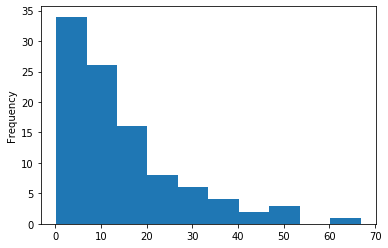

In [611]:
fantasypros_avg_draft[fantasypros_avg_draft['adp_expert_delta'] > 0]['adp_expert_delta'].plot(kind="hist")

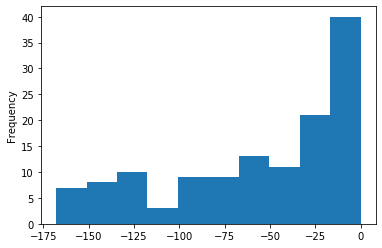

In [613]:
fantasypros_avg_draft[fantasypros_avg_draft['adp_expert_delta'] < 0]['adp_expert_delta'].plot(kind="hist")

Jeesh. Who has the < -150 delta?

In [614]:
fantasypros_avg_draft[fantasypros_avg_draft['adp_expert_delta'] < -150][['full_name', 'adp_expert_delta', "AVG PICK", "expert_average"]]

,full_name,adp_expert_delta,AVG PICK,expert_average
156,Larry Fitzgerald,-164.1,169.9,334.0
161,John Ross,-156.0,170.0,326.0
163,Danny Amendola,-163.0,170.0,333.0
167,Dede Westbrook,-162.0,170.0,332.0
169,Greg Ward,-168.0,170.0,338.0
171,Miles Boykin,-160.0,170.0,330.0
193,Kendrick Bourne,-152.9,170.1,323.0


In [618]:
fantasypros_avg_draft[fantasypros_avg_draft['adp_expert_delta'] > 50][['full_name', 'adp_expert_delta', "AVG PICK", "expert_average"]]

,full_name,adp_expert_delta,AVG PICK,expert_average
88,Trey Sermon,66.8,126.0,59.2
89,Tyler Higbee,50.7,129.7,79.0
122,Kirk Cousins,51.8,164.6,112.8


<a id="champs"></a>
## Historical wins

In [374]:
the_asylum = pd.read_parquet("data/asylum-2020-results.parquet")

Okay so here's me in the 2020 season (Password is Taco)

In [375]:
the_asylum

,Rank,Team,W-L-T,Pts For,Pts Agnst,Streak,Waiver,Moves
0,*1,logo 4th and 20,9-4-0,1589.92,1443.32,W-1,11,27
1,*2,logo Día de Muerte,9-4-0,1535.82,1417.54,W-1,12,90
2,*3,logo Password is Taco,8-5-0,1411.46,1346.78,W-3,2,4
3,*4,logo L.O.P.,8-5-0,1560.30,1466.76,W-3,9,22
4,*5,logo Wheel Snipe Celly,7-6-0,1536.48,1421.98,L-3,10,11
5,*6,logo Wolfpack,7-6-0,1520.70,1451.26,W-3,8,39
6,7,logo Jellyz,4-9-0,1427.60,1543.56,L-3,3,12
7,8,logo Ladies and Edelman,6-7-0,1511.18,1557.02,L-4,7,51
8,9,logo DOWNTOWN BROWN,3-10-0,1321.46,1593.56,L-1,5,7
9,10,logo Merk squad,6-7-0,1471.22,1554.58,W-2,1,19


Let's get rid of that word logo. According to [this incredibly helpful stack overflow that you should upvote](https://stackoverflow.com/a/53565809/7933454), you can use replace with `regex=True`

In [376]:
the_asylum['Team'] = the_asylum['Team'].replace("logo ", "", regex=True)

In [377]:
team_names = list(the_asylum['Team'].values)

In [378]:
import string
whitelist = string.ascii_letters + string.digits + ' '

In [379]:
for i in range(len(team_names)):
    if '\ue010' in team_names[i]:
        new_s = ''.join(c for c in team_names[i] if c in whitelist)
        team_names[i] = new_s

In [380]:
team_names

['4th and 20',
 'Da de Muerte',
 'Password is Taco',
 'L.O.P.',
 'Wheel Snipe Celly',
 'Wolfpack',
 'Jellyz',
 'Ladies and Edelman',
 'DOWNTOWN BROWN',
 'Merk squad',
 "Lee's Legendary Team",
 'Baby Chark']

Much better. Except I see that the í in Día de Muerte was knocked out. 

In [381]:
team_names[1] = "Día de Muerte"

In [382]:
the_asylum

,Rank,Team,W-L-T,Pts For,Pts Agnst,Streak,Waiver,Moves
0,*1,4th and 20,9-4-0,1589.92,1443.32,W-1,11,27
1,*2,Día de Muerte,9-4-0,1535.82,1417.54,W-1,12,90
2,*3,Password is Taco,8-5-0,1411.46,1346.78,W-3,2,4
3,*4,L.O.P.,8-5-0,1560.30,1466.76,W-3,9,22
4,*5,Wheel Snipe Celly,7-6-0,1536.48,1421.98,L-3,10,11
5,*6,Wolfpack,7-6-0,1520.70,1451.26,W-3,8,39
6,7,Jellyz,4-9-0,1427.60,1543.56,L-3,3,12
7,8,Ladies and Edelman,6-7-0,1511.18,1557.02,L-4,7,51
8,9,DOWNTOWN BROWN,3-10-0,1321.46,1593.56,L-1,5,7
9,10,Merk squad,6-7-0,1471.22,1554.58,W-2,1,19


In [383]:
the_asylum['Team'] = team_names

In [384]:
the_asylum

,Rank,Team,W-L-T,Pts For,Pts Agnst,Streak,Waiver,Moves
0,*1,4th and 20,9-4-0,1589.92,1443.32,W-1,11,27
1,*2,Día de Muerte,9-4-0,1535.82,1417.54,W-1,12,90
2,*3,Password is Taco,8-5-0,1411.46,1346.78,W-3,2,4
3,*4,L.O.P.,8-5-0,1560.30,1466.76,W-3,9,22
4,*5,Wheel Snipe Celly,7-6-0,1536.48,1421.98,L-3,10,11
5,*6,Wolfpack,7-6-0,1520.70,1451.26,W-3,8,39
6,7,Jellyz,4-9-0,1427.60,1543.56,L-3,3,12
7,8,Ladies and Edelman,6-7-0,1511.18,1557.02,L-4,7,51
8,9,DOWNTOWN BROWN,3-10-0,1321.46,1593.56,L-1,5,7
9,10,Merk squad,6-7-0,1471.22,1554.58,W-2,1,19


One more thing - I think the asterisk next to rank is just an indicator of playoff/not playoff

In [385]:
the_asylum['Rank'] = the_asylum['Rank'].str.replace("\\*", "", regex=True).astype(int)

In [386]:
the_asylum

,Rank,Team,W-L-T,Pts For,Pts Agnst,Streak,Waiver,Moves
0,1,4th and 20,9-4-0,1589.92,1443.32,W-1,11,27
1,2,Día de Muerte,9-4-0,1535.82,1417.54,W-1,12,90
2,3,Password is Taco,8-5-0,1411.46,1346.78,W-3,2,4
3,4,L.O.P.,8-5-0,1560.30,1466.76,W-3,9,22
4,5,Wheel Snipe Celly,7-6-0,1536.48,1421.98,L-3,10,11
5,6,Wolfpack,7-6-0,1520.70,1451.26,W-3,8,39
6,7,Jellyz,4-9-0,1427.60,1543.56,L-3,3,12
7,8,Ladies and Edelman,6-7-0,1511.18,1557.02,L-4,7,51
8,9,DOWNTOWN BROWN,3-10-0,1321.46,1593.56,L-1,5,7
9,10,Merk squad,6-7-0,1471.22,1554.58,W-2,1,19


Clean!

Okay. I bet there's info in the for and against columns. I wonder if there's a magic multiplier.

In [387]:
the_asylum['pts_for_against_ratio'] = the_asylum['Pts Agnst'] / the_asylum['Pts For']

In [388]:
the_asylum

,Rank,Team,W-L-T,Pts For,Pts Agnst,Streak,Waiver,Moves,pts_for_against_ratio
0,1,4th and 20,9-4-0,1589.92,1443.32,W-1,11,27,0.907794
1,2,Día de Muerte,9-4-0,1535.82,1417.54,W-1,12,90,0.922986
2,3,Password is Taco,8-5-0,1411.46,1346.78,W-3,2,4,0.954175
3,4,L.O.P.,8-5-0,1560.30,1466.76,W-3,9,22,0.940050
4,5,Wheel Snipe Celly,7-6-0,1536.48,1421.98,L-3,10,11,0.925479
5,6,Wolfpack,7-6-0,1520.70,1451.26,W-3,8,39,0.954337
6,7,Jellyz,4-9-0,1427.60,1543.56,L-3,3,12,1.081227
7,8,Ladies and Edelman,6-7-0,1511.18,1557.02,L-4,7,51,1.030334
8,9,DOWNTOWN BROWN,3-10-0,1321.46,1593.56,L-1,5,7,1.205909
9,10,Merk squad,6-7-0,1471.22,1554.58,W-2,1,19,1.056660


Okay so clearly there's a trend here. The top 6 (AKA people who make playoffs) all have a ratio lower than 1, except for Lee's Legendary team. I'm curious about the Points a team scored relative to win loss ratio. Also, I definitely lucked out. I've got the 2nd lowest points in the league behind Lee's Legendary team.

In [389]:
the_asylum['wins'] = the_asylum['W-L-T'].apply(lambda x: x.split("-")[0]).astype(int)
the_asylum['losses'] = the_asylum['W-L-T'].apply(lambda x: x.split("-")[1]).astype(int)
# I decided to comment this out: no one in our league had a tie
#the_asylum['ties'] = the_asylum['W-L-T'].apply(lambda x: x.split("-")[2]).astype(int)

In [390]:
the_asylum['win_loss_ratio'] = the_asylum['wins'] / the_asylum['losses']

In [391]:
the_asylum[['Team', 'pts_for_against_ratio', 'win_loss_ratio']]

,Team,pts_for_against_ratio,win_loss_ratio
0,4th and 20,0.907794,2.250000
1,Día de Muerte,0.922986,2.250000
2,Password is Taco,0.954175,1.600000
3,L.O.P.,0.940050,1.600000
4,Wheel Snipe Celly,0.925479,1.166667
5,Wolfpack,0.954337,1.166667
6,Jellyz,1.081227,0.444444
7,Ladies and Edelman,1.030334,0.857143
8,DOWNTOWN BROWN,1.205909,0.300000
9,Merk squad,1.056660,0.857143


In [392]:
the_asylum['abs_point_delta'] = abs(the_asylum['Pts For'] - the_asylum['Pts Agnst'])
the_asylum['point_delta'] = the_asylum['Pts For'] - the_asylum['Pts Agnst']

In [393]:
the_asylum

,Rank,Team,W-L-T,Pts For,Pts Agnst,Streak,Waiver,Moves,pts_for_against_ratio,wins,losses,win_loss_ratio,abs_point_delta,point_delta
0,1,4th and 20,9-4-0,1589.92,1443.32,W-1,11,27,0.907794,9,4,2.250000,146.60,146.60
1,2,Día de Muerte,9-4-0,1535.82,1417.54,W-1,12,90,0.922986,9,4,2.250000,118.28,118.28
2,3,Password is Taco,8-5-0,1411.46,1346.78,W-3,2,4,0.954175,8,5,1.600000,64.68,64.68
3,4,L.O.P.,8-5-0,1560.30,1466.76,W-3,9,22,0.940050,8,5,1.600000,93.54,93.54
4,5,Wheel Snipe Celly,7-6-0,1536.48,1421.98,L-3,10,11,0.925479,7,6,1.166667,114.50,114.50
5,6,Wolfpack,7-6-0,1520.70,1451.26,W-3,8,39,0.954337,7,6,1.166667,69.44,69.44
6,7,Jellyz,4-9-0,1427.60,1543.56,L-3,3,12,1.081227,4,9,0.444444,115.96,-115.96
7,8,Ladies and Edelman,6-7-0,1511.18,1557.02,L-4,7,51,1.030334,6,7,0.857143,45.84,-45.84
8,9,DOWNTOWN BROWN,3-10-0,1321.46,1593.56,L-1,5,7,1.205909,3,10,0.300000,272.10,-272.10
9,10,Merk squad,6-7-0,1471.22,1554.58,W-2,1,19,1.056660,6,7,0.857143,83.36,-83.36


I wonder if I could get player level info

In [102]:
driver = webdriver.Firefox()
driver.get("https://football.fantasysports.yahoo.com/2020/f1/759915/1")
# Note this will prompt you to sign in, so have your phone nearby

In [103]:
all_fantasy_teams = []
for i in range(1, len(the_asylum)+1):
    driver.get(f"https://football.fantasysports.yahoo.com/2020/f1/759915/{i}")
    sleep(3)
    this_season = driver.find_element_by_xpath('/html/body/div[1]/div[2]/div[2]/div[2]/div/div/div[2]/div[2]/section/div/div/div[3]/section[1]/header/div[1]/div[3]/div/ul[1]/li[3]/a')
    this_season.click()
    sleep(2)
    df = pd.read_html(driver.page_source)[0]
    df.columns = df.columns.droplevel()
    all_fantasy_teams.append(df)
driver.close()
    

I can absolutely get info about each team. Let's do that by running the above scraper

Scraper in action!
<img src = "assets/scraping-players1.png" width=300 height=300>
<img src = "assets/scraping-players2.png" width=300 height=300>
<img src = "assets/scraping-players3.png" width=300 height=300>
<img src = "assets/scraping-players4.png" width=300 height=300>
<img src = "assets/scraping-players5.png" width=300 height=300>

In [104]:
len(all_fantasy_teams)

12

In [109]:
all_fantasy_teams[0].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Pos,QB,WR,WR,RB,RB,TE,W/R/T,BN,BN,BN,BN,BN,BN,IR,IR,IR
Offense,No new player Notes Russell Wilson Final W 20...,No new player Notes DK Metcalf Final W 20-9 v...,Player Note Chris Godwin Final W 47-7 @ Det,Player Note Wayne Gallman Jr. Final L 14-17 @ KC,No new player Notes Mike Davis Final L 14-17 ...,No new player Notes Darren Waller Final L 25-...,No new player Notes Russell Gage Final L 14-1...,Player Note Peyton Barber Final L 25-26 vs Mia,Player Note Zack Moss Final W 38-9 @ NE,No new player Notes Devontae Booker Final L 1...,Player Note Brandon Aiyuk Final W 20-12 @ Ari,No new player Notes Carlos Hyde Final L 17-41...,No new player Notes Michael Gallup Final W 37...,Player Note Kenny Golladay Final L 13-27 @ Bal,No new player Notes Antonio Gibson Final L 13...,No new player Notes Justin Jackson Final W 19...
Action,,,,,,,,,,,,,,,,
Action,,,,,,,,,,,,,,,,
Bye,6,6,13,10,10,6,10,6,11,11,11,8,10,11,8,6
Fan Pts,414.78,235.8,158.5,126.1,177.0,235.1,146.06,53.0,94.6,77.2,154.5,76.9,143.8,55.8,184.2,55.8
% Start,77%,93%,74%,33%,50%,96%,20%,1%,18%,4%,72%,3%,17%,10%,38%,1%
Yds,4212,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0
TD,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Int,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


That symbol in the team names is bugging me. I'm going to remove it to get cleaner names

Now I'm going to create a dataframe of all teams and then I'll be able to think about each stat across team names

In [396]:
asylum_players = pd.concat(all_fantasy_teams, axis=1, keys=team_names)

#asylum_players.to_csv("data/asylum-2020-player-level-info.csv")

# You can just read in the dataframe if you don't want to scrape again:
# asylum_players = pd.read_csv("data/asylum-2020-player-level-info.csv")

In [397]:
asylum_players.head(2)

4th and 20                                                                   \
         Pos                                            Offense Action Action   
0         QB  No new player Notes  Russell Wilson Final W 20...               
1         WR  No new player Notes  DK Metcalf Final W 20-9 v...               

                                     ... Baby Chark                            \
  Bye Fan Pts % Start   Yds  TD Int  ...        Yds   TD   Tgt*   Rec     Yds   
0   6  414.78     77%  4212  40  13  ...      444.0  3.0    0.0   0.0     0.0   
1   6  235.80     93%     0   0   0  ...       14.0  0.0  130.0  92.0  1114.0   

                                           
    TD   TD  2PT Lost Unnamed: 20_level_1  
0  0.0  0.0  1.0  3.0                 NaN  
1  5.0  0.0  1.0  0.0                 NaN  

[2 rows x 250 columns]

Okay first metric I'm interested in is how many points each position earned for a that fantasy manager. Let's see those points on teams

In [398]:
positions = list(all_fantasy_teams[0]['Pos'].values)

In [399]:
fantasy_points_by_team = asylum_players.xs('Fan Pts',level=1, axis=1).copy()

In [400]:
fantasy_points_by_team['Position'] = positions

In [401]:
fantasy_points_by_team.set_index('Position', inplace=True)

In [402]:
fantasy_points_by_team

,4th and 20,Día de Muerte,Password is Taco,L.O.P.,Wheel Snipe Celly,Wolfpack,Jellyz,Ladies and Edelman,DOWNTOWN BROWN,Merk squad,Lee's Legendary Team,Baby Chark
Position,,,,,,,,,,,,
QB,414.78,120.94,398.92,387.84,445.76,464.56,242.48,417.74,446.80,277.98,360.20,432.32
WR,235.80,268.10,236.30,239.50,177.80,218.30,297.40,200.10,63.90,309.90,180.30,190.80
WR,158.50,236.20,197.50,161.90,167.50,176.60,81.30,216.60,183.90,185.60,217.00,178.50
RB,126.10,237.80,156.40,238.40,99.30,166.80,352.60,138.30,225.90,199.70,339.30,328.80
RB,177.00,143.70,118.50,214.80,151.40,182.70,161.70,91.70,182.40,249.80,147.10,169.30
TE,235.10,263.26,126.80,93.40,60.10,141.10,108.90,121.10,90.50,150.60,141.80,104.10
W/R/T,146.06,162.50,162.70,70.50,161.00,211.90,192.80,118.02,59.50,122.30,199.50,94.60
BN,53.00,358.78,69.30,106.80,175.30,197.70,195.10,131.60,71.10,152.96,173.60,109.50
BN,94.60,222.40,385.78,123.70,123.60,113.80,280.12,70.40,180.70,124.60,134.60,136.20


So I can't really compare from the bench down because those are without order (i.e. Password is Taco might have a QB in the first BN slot, and Wolfpack might have a WR. 

I can however calculate across the rows and look at some stats

In [403]:
starters = positions[:7]

In [404]:
fantasy_points_by_team.loc[starters, :].mean()

4th and 20              199.158182
Día de Muerte           210.754545
Password is Taco        191.438182
L.O.P.                  205.540000
Wheel Snipe Celly       168.987273
Wolfpack                209.669091
Jellyz                  211.834545
Ladies and Edelman      177.296364
DOWNTOWN BROWN          173.545455
Merk squad              221.898182
Lee's Legendary Team    224.445455
Baby Chark              215.074545
dtype: float64

Median points across teams

In [405]:
fantasy_points_by_team.loc[starters, :].median()

4th and 20              177.0
Día de Muerte           236.2
Password is Taco        162.7
L.O.P.                  214.8
Wheel Snipe Celly       161.0
Wolfpack                182.7
Jellyz                  192.8
Ladies and Edelman      138.3
DOWNTOWN BROWN          182.4
Merk squad              199.7
Lee's Legendary Team    199.5
Baby Chark              178.5
dtype: float64

Same info but make it visual

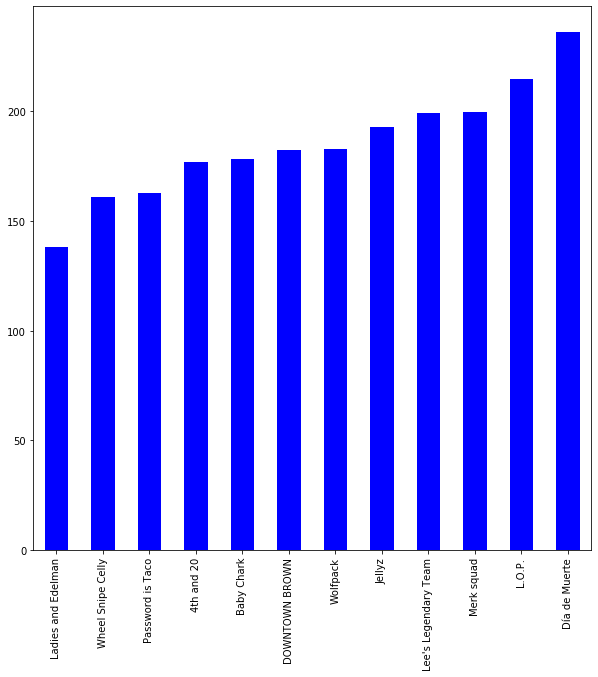

In [406]:
(fantasy_points_by_team.loc[starters, :]
 .median()
 .sort_values()
 .plot(kind="bar", figsize=(10,10), color="Blue"))

The cynical side of me is noticing that myself and 4th and 20 have pretty low metrics but still ended up in 3rd and 1st place respectively. Maybe this is all luck 😂 


Checking out player over player:

In [407]:
fantasy_points_by_team.mean(axis=1)

Position
QB       367.526667
WR       218.183333
WR       180.091667
RB       217.450000
RB       165.841667
TE       136.396667
W/R/T    141.781667
BN       149.561667
BN       165.875000
BN       122.238333
BN       140.958333
BN       108.714000
BN       136.357778
IR        76.066667
IR       184.200000
IR        55.800000
dtype: float64

In [408]:
fantasy_points_by_team.median(axis=1)

Position
QB       406.85
WR       227.05
WR       181.20
RB       212.80
RB       165.50
TE       123.95
W/R/T    153.53
BN       142.28
BN       129.60
BN       106.75
BN       138.15
BN       113.65
BN       118.30
IR        80.30
IR       184.20
IR        55.80
dtype: float64

Prevailing wisdom is to usually draft RBs first, maybe WRs but it's interesting that QBs dominate in points.

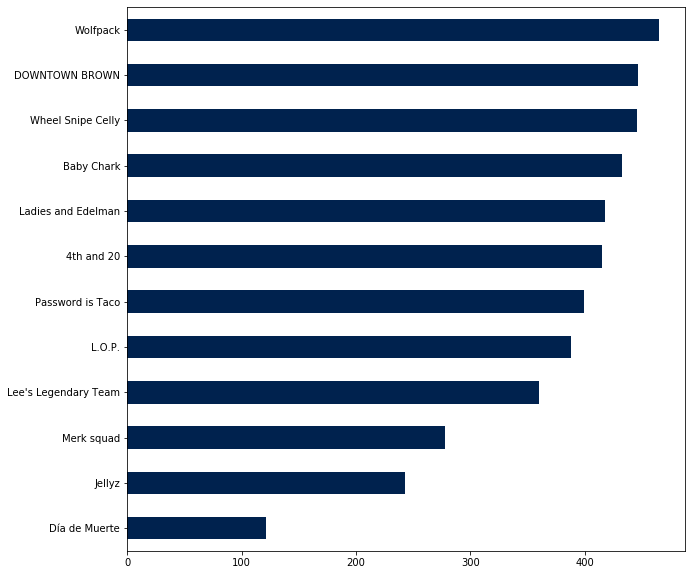

In [409]:
(fantasy_points_by_team.loc['QB']
 .sort_values()
 .plot(kind='barh', 
       cmap='cividis',
      figsize=(10,10)))

Okay maybe it's not all luck, but there is an element of fate. Interesting that the manager with the lowest scoring QB ended up in 2nd  place.

In [410]:
the_asylum.loc[the_asylum['Team'].isin(['Día de Muerte', 'Jellyz']), ["Team", "Rank"]]

,Team,Rank
1,Día de Muerte,2
6,Jellyz,7


I wonder if I could attach a metric that identified who was the manager with the highest scoring across every position.

In [411]:
fantasy_points_by_team['best_score'] = fantasy_points_by_team.max(axis=1)

In [412]:
fantasy_points_by_team['worst_score'] = fantasy_points_by_team.min(axis=1)

In [413]:
def position_delta(colum):
    max_delta = fantasy_points_by_team[colum] - fantasy_points_by_team['best_score'] 
    min_delta = fantasy_points_by_team[colum] - fantasy_points_by_team['worst_score']
    return pd.Series([max_delta, min_delta])

In [414]:
for i in fantasy_points_by_team.columns[:-2]:
    fantasy_points_by_team[[i+"_max_delta", i+"_min_delta"]] = position_delta(i)

In [415]:
fantasy_points_by_team

,4th and 20,Día de Muerte,Password is Taco,L.O.P.,Wheel Snipe Celly,Wolfpack,Jellyz,Ladies and Edelman,DOWNTOWN BROWN,Merk squad,...,Ladies and Edelman_max_delta,Ladies and Edelman_min_delta,DOWNTOWN BROWN_max_delta,DOWNTOWN BROWN_min_delta,Merk squad_max_delta,Merk squad_min_delta,Lee's Legendary Team_max_delta,Lee's Legendary Team_min_delta,Baby Chark_max_delta,Baby Chark_min_delta
Position,,,,,,,,,,,,,,,,,,,,,
QB,414.78,120.94,398.92,387.84,445.76,464.56,242.48,417.74,446.80,277.98,...,-46.82,296.80,-17.76,325.86,-186.58,157.04,-104.36,239.26,-32.24,311.38
WR,235.80,268.10,236.30,239.50,177.80,218.30,297.40,200.10,63.90,309.90,...,-109.80,136.20,-246.00,0.00,0.00,246.00,-129.60,116.40,-119.10,126.90
WR,158.50,236.20,197.50,161.90,167.50,176.60,81.30,216.60,183.90,185.60,...,-19.60,135.30,-52.30,102.60,-50.60,104.30,-19.20,135.70,-57.70,97.20
RB,126.10,237.80,156.40,238.40,99.30,166.80,352.60,138.30,225.90,199.70,...,-214.30,39.00,-126.70,126.60,-152.90,100.40,-13.30,240.00,-23.80,229.50
RB,177.00,143.70,118.50,214.80,151.40,182.70,161.70,91.70,182.40,249.80,...,-158.10,0.00,-67.40,90.70,0.00,158.10,-102.70,55.40,-80.50,77.60
TE,235.10,263.26,126.80,93.40,60.10,141.10,108.90,121.10,90.50,150.60,...,-142.16,61.00,-172.76,30.40,-112.66,90.50,-121.46,81.70,-159.16,44.00
W/R/T,146.06,162.50,162.70,70.50,161.00,211.90,192.80,118.02,59.50,122.30,...,-93.88,58.52,-152.40,0.00,-89.60,62.80,-12.40,140.00,-117.30,35.10
BN,53.00,358.78,69.30,106.80,175.30,197.70,195.10,131.60,71.10,152.96,...,-227.18,78.60,-287.68,18.10,-205.82,99.96,-185.18,120.60,-249.28,56.50
BN,94.60,222.40,385.78,123.70,123.60,113.80,280.12,70.40,180.70,124.60,...,-315.38,0.00,-205.08,110.30,-261.18,54.20,-251.18,64.20,-249.58,65.80


In [416]:
def print_team_delta_stats(team):
    that_team = [x for x in fantasy_points_by_team.columns if team in x]
    for i in that_team:
        print("Manager's position stats:", fantasy_points_by_team[i])

In [417]:
def df_team_delta_stats(team):
    that_team = [x for x in fantasy_points_by_team.columns if team in x]
    that_team.extend(["best_score", "worst_score"])
    return fantasy_points_by_team.loc[starters, that_team]

In [418]:
for i in fantasy_points_by_team.loc[starters, :]:
    print_team_delta_stats(i)

Manager's position stats: Position
QB       414.78
WR       235.80
WR       158.50
RB       126.10
RB       177.00
TE       235.10
W/R/T    146.06
BN        53.00
BN        94.60
BN        77.20
BN       154.50
BN        76.90
BN       143.80
IR        55.80
IR       184.20
IR        55.80
Name: 4th and 20, dtype: float64
Manager's position stats: Position
QB       -49.78
WR       -74.10
WR       -77.70
RB      -226.50
RB       -72.80
TE       -28.16
W/R/T    -65.84
BN      -305.78
BN      -291.18
BN      -250.24
BN      -119.48
BN       -84.20
BN      -171.42
IR       -36.30
IR         0.00
IR         0.00
Name: 4th and 20_max_delta, dtype: float64
Manager's position stats: Position
QB       293.84
WR       171.90
WR        77.20
RB        26.80
RB        85.30
TE       175.00
W/R/T     86.56
BN         0.00
BN        24.20
BN        10.60
BN        71.40
BN        25.60
BN        74.30
IR         0.00
IR         0.00
IR         0.00
Name: 4th and 20_min_delta, dtype: float64
Manager'

In [419]:
df_team_delta_stats("Password is Taco")

,Password is Taco,Password is Taco_max_delta,Password is Taco_min_delta,best_score,worst_score
Position,,,,,
QB,398.92,-65.64,277.98,464.56,120.94
WR,236.30,-73.60,172.40,309.90,63.90
WR,197.50,-38.70,116.20,236.20,81.30
WR,236.30,-73.60,172.40,309.90,63.90
WR,197.50,-38.70,116.20,236.20,81.30
RB,156.40,-196.20,57.10,352.60,99.30
RB,118.50,-131.30,26.80,249.80,91.70
RB,156.40,-196.20,57.10,352.60,99.30
RB,118.50,-131.30,26.80,249.80,91.70


I'm thinking that this is where some valuable information might lie (pun intended). If I could see manager vs. manager and compare their deltas, maybe that will shed some light on how much better than the average/min/max one manager needs to do in order to be successful?

In [420]:
import matplotlib.pyplot as plt

In [421]:
def df_team_comparison(team):
    that_team = [x for x in fantasy_points_by_team.columns if team in x]
    that_team.extend(["best_score", "worst_score"])
    df = fantasy_points_by_team.loc[starters, that_team].copy()
    df['max_ratio'] = df['best_score'] / df[team] 
    df['min_ratio'] = df['worst_score'] / df[team] 
    average_points = df[team].mean()
    print("average points for this team's players", average_points)
    df[['max_ratio', 'min_ratio']].plot(kind='bar')
    plt.title(team)
    return df

average points for this team's players 191.43818181818185


,Password is Taco,Password is Taco_max_delta,Password is Taco_min_delta,best_score,worst_score,max_ratio,min_ratio
Position,,,,,,,
QB,398.92,-65.64,277.98,464.56,120.94,1.164544,0.303169
WR,236.30,-73.60,172.40,309.90,63.90,1.311468,0.270419
WR,197.50,-38.70,116.20,236.20,81.30,1.195949,0.411646
WR,236.30,-73.60,172.40,309.90,63.90,1.311468,0.270419
WR,197.50,-38.70,116.20,236.20,81.30,1.195949,0.411646
RB,156.40,-196.20,57.10,352.60,99.30,2.254476,0.634910
RB,118.50,-131.30,26.80,249.80,91.70,2.108017,0.773840
RB,156.40,-196.20,57.10,352.60,99.30,2.254476,0.634910
RB,118.50,-131.30,26.80,249.80,91.70,2.108017,0.773840


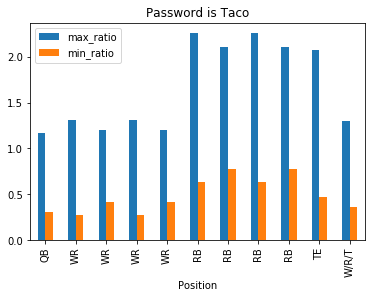

In [422]:
df_team_comparison("Password is Taco")

average points for this team's players 199.1581818181818


,4th and 20,4th and 20_max_delta,4th and 20_min_delta,best_score,worst_score,max_ratio,min_ratio
Position,,,,,,,
QB,414.78,-49.78,293.84,464.56,120.94,1.120015,0.291576
WR,235.80,-74.10,171.90,309.90,63.90,1.314249,0.270992
WR,158.50,-77.70,77.20,236.20,81.30,1.490221,0.512934
WR,235.80,-74.10,171.90,309.90,63.90,1.314249,0.270992
WR,158.50,-77.70,77.20,236.20,81.30,1.490221,0.512934
RB,126.10,-226.50,26.80,352.60,99.30,2.796193,0.787470
RB,177.00,-72.80,85.30,249.80,91.70,1.411299,0.518079
RB,126.10,-226.50,26.80,352.60,99.30,2.796193,0.787470
RB,177.00,-72.80,85.30,249.80,91.70,1.411299,0.518079


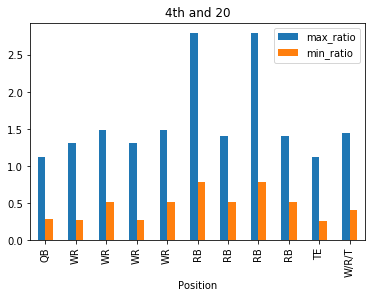

In [423]:
df_team_comparison("4th and 20")

average points for this team's players 210.75454545454548


,Día de Muerte,Día de Muerte_max_delta,Día de Muerte_min_delta,best_score,worst_score,max_ratio,min_ratio
Position,,,,,,,
QB,120.94,-343.62,0.00,464.56,120.94,3.841244,1.000000
WR,268.10,-41.80,204.20,309.90,63.90,1.155912,0.238344
WR,236.20,0.00,154.90,236.20,81.30,1.000000,0.344200
WR,268.10,-41.80,204.20,309.90,63.90,1.155912,0.238344
WR,236.20,0.00,154.90,236.20,81.30,1.000000,0.344200
RB,237.80,-114.80,138.50,352.60,99.30,1.482759,0.417578
RB,143.70,-106.10,52.00,249.80,91.70,1.738344,0.638135
RB,237.80,-114.80,138.50,352.60,99.30,1.482759,0.417578
RB,143.70,-106.10,52.00,249.80,91.70,1.738344,0.638135


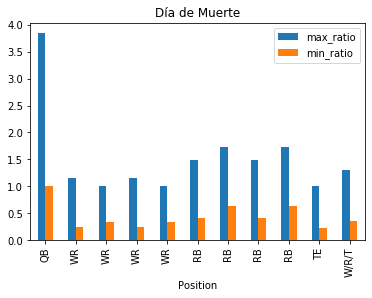

In [424]:
df_team_comparison("Día de Muerte")


4th and 20
average points for this team's players 199.1581818181818
🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈

Día de Muerte
average points for this team's players 210.75454545454548
🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈

Password is Taco
average points for this team's players 191.43818181818185
🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈

L.O.P.
average points for this team's players 205.54
🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈

Wheel Snipe Celly
average points for this team's players 168.9872727272727
🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈

Wolfpack
average points for this team's players 209.66909090909093
🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈

Jellyz
average points for this team's players 211.8345454545455
🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈

Ladies and Edelman
average points for this team's players 177.29636363636362
🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈

DOWNTOWN BROWN
average points for this team's players 173.54545454545456
🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈

Merk squad
average points for this team's players 221.89818181818183
🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈🏈

Lee's Legendary Team
average points for this team's players 224.44545454545457
🏈🏈🏈🏈🏈🏈🏈

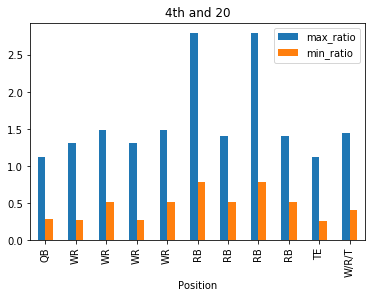

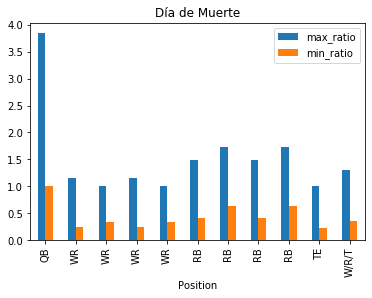

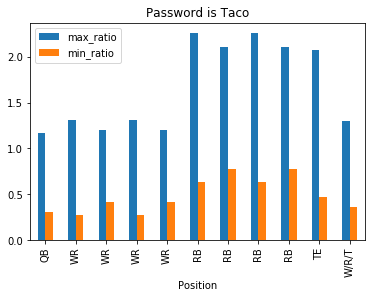

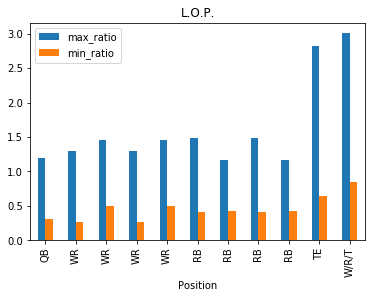

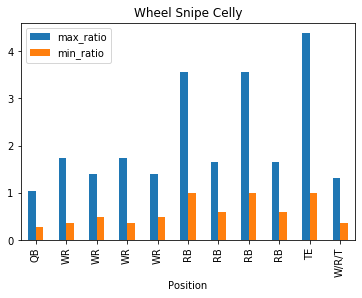

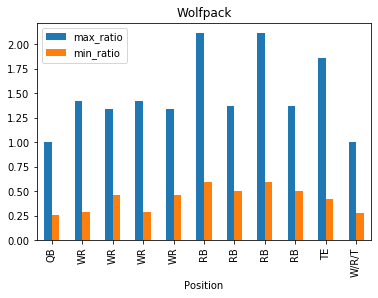

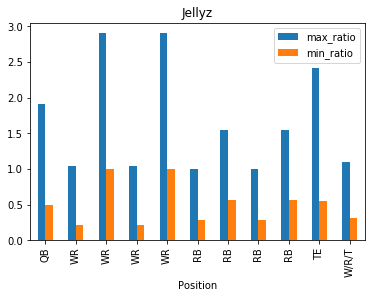

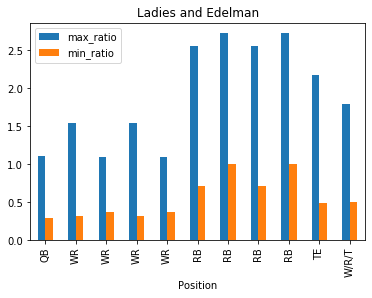

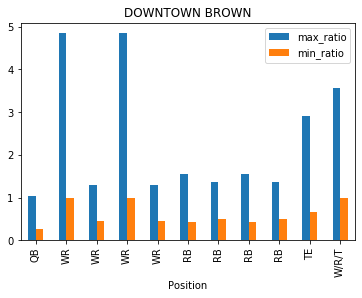

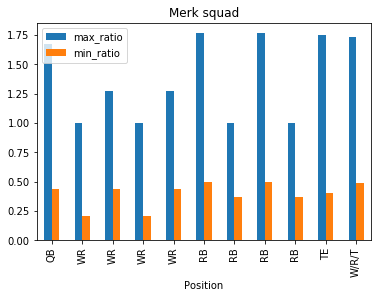

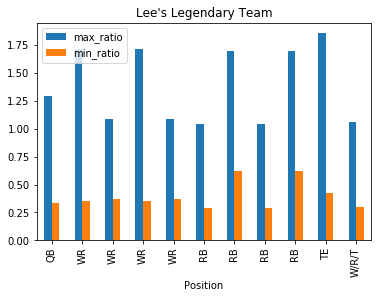

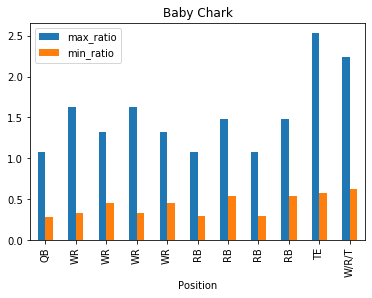

In [425]:
for i in fantasy_points_by_team.columns:
    if i in team_names:
        print()
        print(i)
        df_team_comparison(i)
        print("🏈"*20)

Okay so I have no intuition at this moment on any patterns.

In [428]:
fantasy_points_by_team.head(6).T

Position,QB,WR,WR,RB,RB,TE
4th and 20,414.78,235.8,158.5,126.1,177.0,235.10
Día de Muerte,120.94,268.1,236.2,237.8,143.7,263.26
Password is Taco,398.92,236.3,197.5,156.4,118.5,126.80
L.O.P.,387.84,239.5,161.9,238.4,214.8,93.40
Wheel Snipe Celly,445.76,177.8,167.5,99.3,151.4,60.10
Wolfpack,464.56,218.3,176.6,166.8,182.7,141.10
Jellyz,242.48,297.4,81.3,352.6,161.7,108.90
Ladies and Edelman,417.74,200.1,216.6,138.3,91.7,121.10
DOWNTOWN BROWN,446.80,63.9,183.9,225.9,182.4,90.50
Merk squad,277.98,309.9,185.6,199.7,249.8,150.60


In [430]:
fantasy_points_by_team.head(6).describe().T

,count,mean,std,min,25%,50%,75%,max
4th and 20,6.0,224.546667,102.704747,126.10,163.125,206.05,235.625,414.78
Día de Muerte,6.0,211.666667,63.217441,120.94,166.825,237.00,256.895,268.10
Password is Taco,6.0,205.736667,104.496029,118.50,134.200,176.95,226.600,398.92
L.O.P.,6.0,222.640000,98.262371,93.40,175.125,226.60,239.225,387.84
Wheel Snipe Celly,6.0,183.643333,135.953142,60.10,112.325,159.45,175.225,445.76
Wolfpack,6.0,225.010000,119.993486,141.10,169.250,179.65,209.400,464.56
Jellyz,6.0,207.396667,107.801295,81.30,122.100,202.09,283.670,352.60
Ladies and Edelman,6.0,197.590000,117.823953,91.70,125.400,169.20,212.475,417.74
DOWNTOWN BROWN,6.0,198.900000,136.129512,63.90,113.475,183.15,215.400,446.80
Merk squad,6.0,228.930000,60.440170,150.60,189.125,224.75,270.935,309.90
